# Function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from matplotlib import cm
from matplotlib import animation, rc
from IPython.display import HTML
import os
%matplotlib inline

In [2]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [3]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    parms = dict()
    parms['max_iters'] = 20
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))

        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

In [4]:
def STA(r, x, v, dt, window):
    negshift=round(window[0]/dt) # second
    posshift=round(window[1]/dt) # second
    xSTS = np.zeros(posshift-negshift)
    vSTS = np.zeros(posshift-negshift)
    for i in np.arange(-negshift, len(r)-posshift):
        xSTS = xSTS + x[i+negshift:i+posshift]*r[i]
        vSTS = vSTS + v[i+negshift:i+posshift]*r[i]
    xSTA = xSTS/sum(r[-negshift:len(r)-posshift])
    vSTA = vSTS/sum(r[-negshift:len(r)-posshift])
    time = np.arange(negshift*dt, posshift*dt, dt)
    return time, xSTA, vSTA

In [5]:
def STcollection(r, x, v, dt, window):
    negshift=round(window[0]/dt) # second
    posshift=round(window[1]/dt) # second
    xcoll = np.zeros(posshift-negshift)
    vcoll = np.zeros(posshift-negshift)
    for i in np.arange(-negshift, len(r)-posshift):
        conter = r[i]
        while conter != 0:
            xcoll = np.vstack((xcoll , x[i+negshift:i+posshift]))
            vcoll = np.vstack((vcoll , v[i+negshift:i+posshift]))
            conter += -1
    time = np.arange(negshift*dt, posshift*dt, dt)
    return time, xcoll[1:], vcoll[1:]

# Main

In [6]:
Tot=300
dt=1./60
T=np.arange(dt,Tot,dt)
# HMM ; input
Gamma = 4.5
Omega = Gamma/2.12
D = 27*10**5
HMM=np.zeros(len(T))
vL =np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    HMM[i+1]=HMM[i]+vL[i]*dt
    vL[i+1]=vL[i]*(1-dt*Gamma)- Omega**2*HMM[i]*dt+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# OU ; input
tau= 1
D = 27*10**5
OU=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)

# LPOU ; input
# filtering for OUSmoothed
cutoffFreq = 1
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)

# White noise ; input
WN = np.random.randn(len(T))

#SinWave; input
SW = np.sin(np.pi*T)

In [7]:
##Choose x and calculate v
x = LPOU  ##HMM or OU or LPOU or WN
v = ndimage.gaussian_filter1d(x, sigma=5, order=1, mode='nearest') / dt

(140, 160)

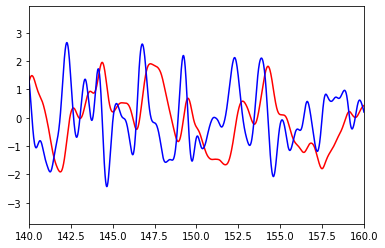

In [8]:
x_n = (x-np.mean(x))/np.std(x)
v_n = (v-np.mean(v))/np.std(v)
plt.plot(T,x_n, 'r-')
plt.plot(T,v_n, 'b-')
plt.xlim(140,160)

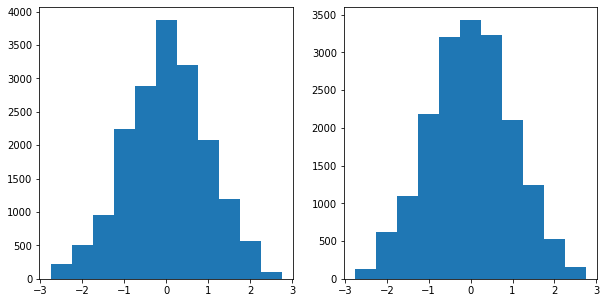

In [9]:
fig, (ax2,ax3) = plt.subplots(1,2)
ax2.hist(x_n, bins = np.arange(-2.75,3.,0.5))
ax3.hist(v_n, bins = np.arange(-2.75,3.,0.5))
fig.set_size_inches(10,5)

0.4833333333333343

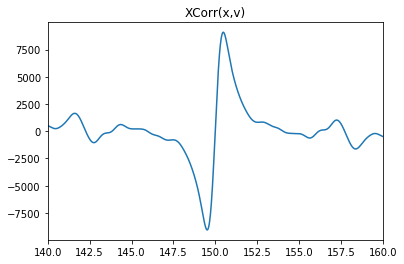

In [10]:
xv_cor = np.correlate(x_n, v_n, "same")
plt.plot(T,xv_cor)
plt.title('XCorr(x,v)')
plt.xlim(140,160)
np.squeeze(T[np.where(xv_cor == max(xv_cor))]-T[np.where(xv_cor == min(xv_cor))])/2

In [11]:
##response
# Model one: simple estimation
# deltaT = 0.5
lamda = 0.45
r1 = (1-lamda)*x+lamda*v

#Chose which one to be response
r = r1
x = x_n
v = v_n

In [12]:
#assign states
rstate=np.zeros(len(r))

#'fake distributed'
edges = np.append(min(r), np.array([-np.std(r),-2*np.std(r),-3*np.std(r)])+np.mean(r));
for i in range(4):
    rstate[r<=edges[i]] = i
rstate = rstate.astype(int)

#equal state
# rstate, edges = EqualState(r, 6)

(0.3416666666666667, -0.09166666666666666, 0.725)

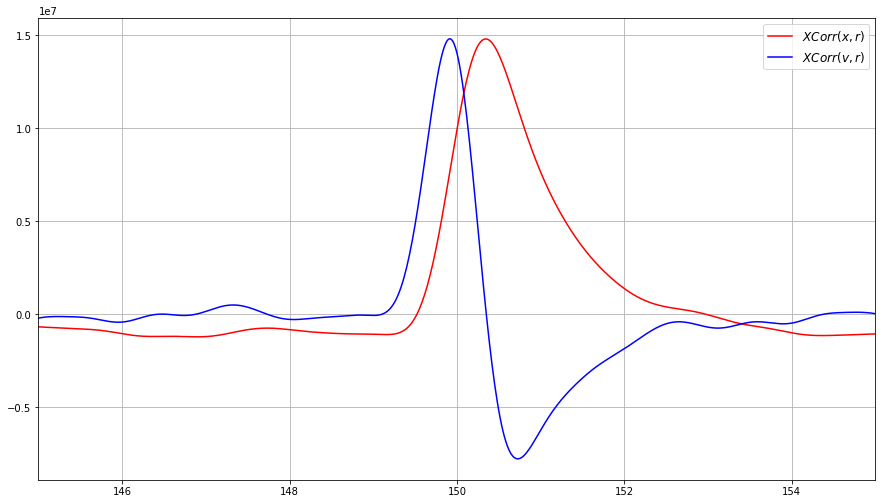

In [13]:
xr_cor = np.correlate(x_n, r, "same")
vr_cor = np.correlate(v_n, r, "same")
plt.plot(T,xr_cor, 'r-')
plt.plot(T,vr_cor, 'b-')
plt.grid()
plt.xlim(145,155)
plt.gcf().set_size_inches(15, 8.5)
plt.legend( (r'$XCorr(x,r)$', r'$XCorr(v,r)$'), loc='best', prop={'size': 'large', 'family': 'monospace'})
(np.squeeze(np.where(xr_cor == max(xr_cor)))-len(T)/2)*dt, (np.squeeze(np.where(vr_cor == max(vr_cor)))-len(T)/2)*dt, (np.squeeze(np.where(vr_cor == min(vr_cor)))-len(T)/2)*dt

In [14]:
#assign states
xstate, edges = EqualState(x, 6)
vstate, edges = EqualState(v, 6)

# xstate = ((x-np.min(x))/((np.max(x)-np.min(x))/6)).astype(int)
# xstate[np.where(xstate==max(xstate))] = 6-1
# vstate = ((v-np.min(v))/((np.max(v)-np.min(v))/6)).astype(int)
# vstate[np.where(vstate==max(vstate))] = 6-1

In [29]:
#calculate STA
window = [-2,2] # second
time, xcoll, vcoll = STcollection(rstate, x, v, dt, window)
xSTA = np.mean(xcoll, axis=0)
vSTA = np.mean(vcoll, axis=0)
xSTstd = np.var(xcoll, axis=0)
vSTstd = np.var(vcoll, axis=0)

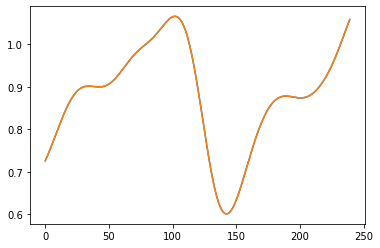

In [30]:
plt.plot(xSTstd)
plt.plot(xSTC)

In [22]:
((xcoll-xSTA[np.newaxis,:])**2).shape

(3391, 240)

In [16]:
#calculate information
timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in multi

# plot MI, STA, STA(x,v)

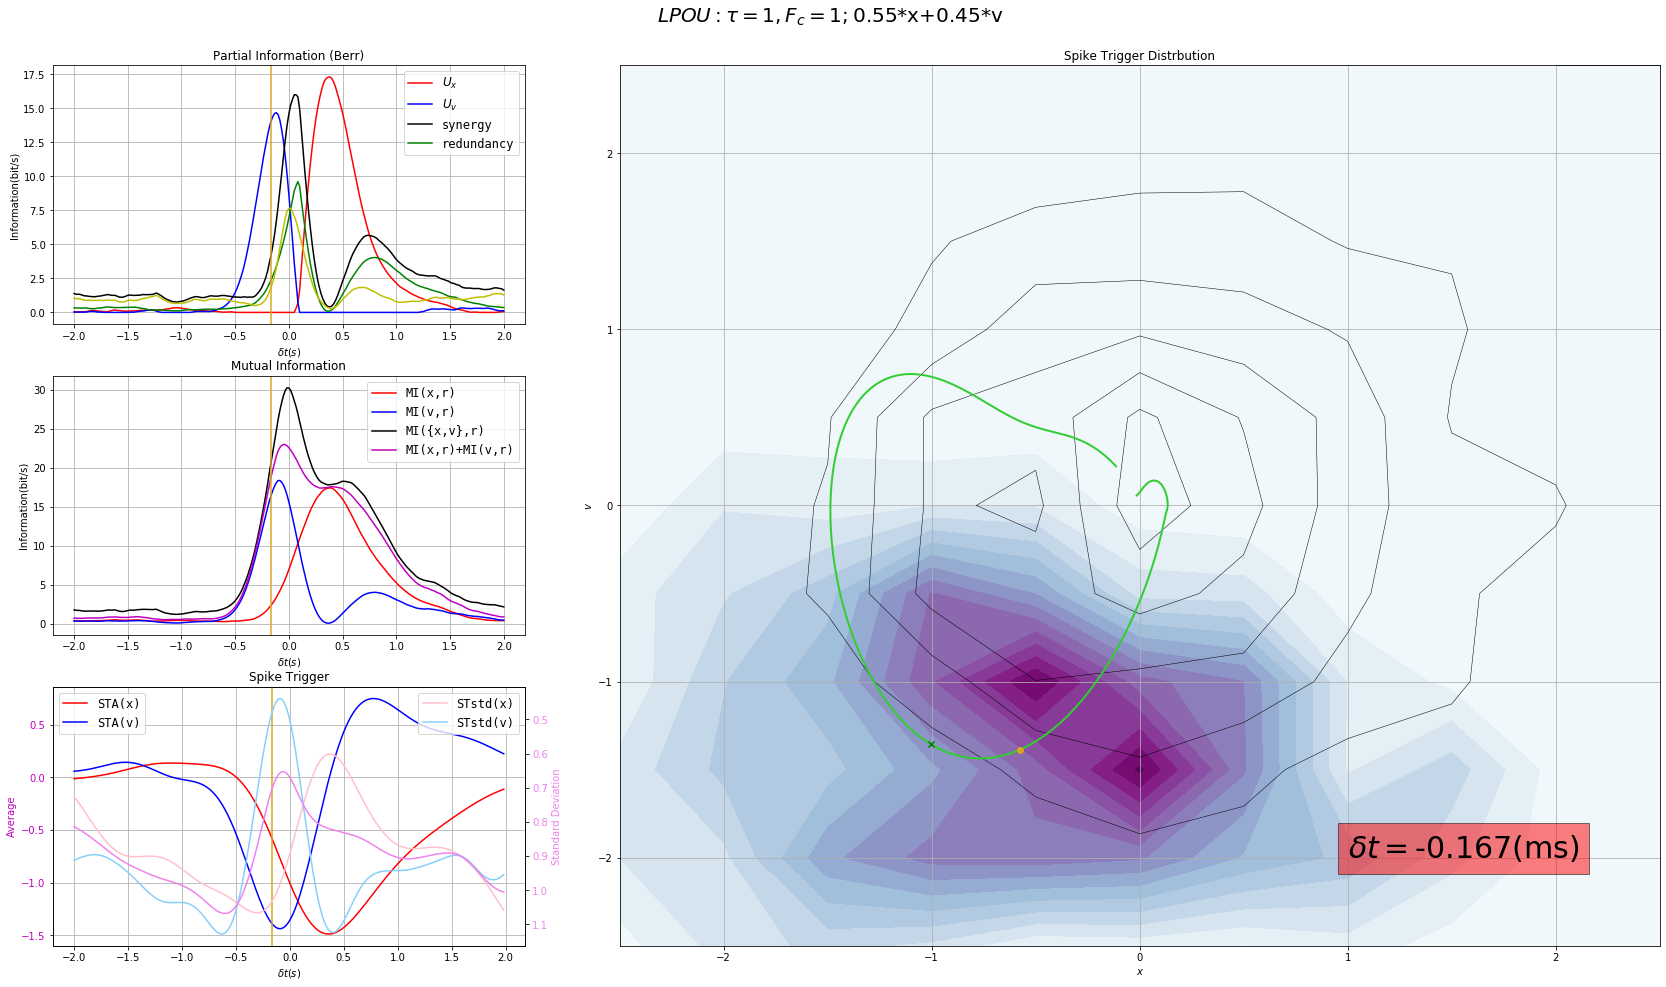

In [17]:
MIx = Information[('Beer','UIx')]+Information[('Beer','Red')]
MIv = Information[('Beer','UIv')]+Information[('Beer','Red')]
MIjoint = Information[('Beer','UIx')]+Information[('Beer','Syn')]+Information[('Beer','UIv')]+Information[('Beer','Red')]
index = int(len(time)/2+0.5)
index = 110
fig = plt.figure()
fig.suptitle(r'$LPOU:\tau=1,F_c=1;$'+str(1-lamda)+'*x+'+str(lamda)+'*v', fontsize = 20, y=0.93)
ax5 = fig.add_subplot(3, 3, 1)
ax2 = fig.add_subplot(3, 3, 4)
ax3 = fig.add_subplot(3, 3, 7)
ax4 = fig.add_subplot(1, 3, (2,5))
#MI
ax2.plot(timeshift,MIx, 'r-')
ax2.plot(timeshift,MIv, 'b-')
ax2.plot(timeshift,MIjoint, 'k-')
ax2.plot(timeshift,MIx+MIv, 'm-')
ax2.axvline(time[index], color = 'goldenrod')
ax2.set_title('Mutual Information')
ax2.set_xlabel(r'$\delta t(s)$')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
#PI
ax5.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax5.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax5.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax5.plot(timeshift,Information[('Beer','Red')], 'g-')
ax5.plot(timeshift,Information[('Beer','Syn')]-Information[('Beer','Red')], 'y-')
ax5.axvline(time[index], color = 'goldenrod')
ax5.set_title('Partial Information (Berr)')
ax5.set_xlabel(r'$\delta t(s)$')
ax5.set_ylabel('Information(bit/s)')
ax5.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax5.grid()
#STA & STstd
ax3.plot(time,xSTA,'r-')
ax3.plot(time,vSTA, 'b-')
ax3.axvline(time[index], color = 'goldenrod')
ax3.set_title('Spike Trigger')
ax3.set_xlabel(r'$\delta t(s)$')
ax3.set_ylabel('Average', color='m')
ax3.tick_params(axis='y', labelcolor='m')
ax3.legend( ('STA(x)', 'STA(v)'), loc='upper left', prop={'size': 'large', 'family': 'monospace'})
ax6 = ax3.twinx()
ax6.invert_yaxis()
ax6.plot(time,xSTstd,'pink')
ax6.plot(time,vSTstd,'lightskyblue')
ax6.plot(time,np.sqrt(vSTstd*xSTstd),'violet')
ax6.set_ylabel('Standard Deviation', color='violet')
ax6.tick_params(axis='y', labelcolor='violet')
ax6.legend( ('STstd(x)', 'STstd(v)'), loc='upper right', prop={'size': 'large', 'family': 'monospace'})
#STdistrbution
dat = np.vstack((x,v))
edges = (np.arange(-2.75,3.,0.5),np.arange(-2.75,3.,0.5))
N, edges= np.histogramdd(dat.T, bins=edges)
Ctrs = [(edges[i][:-1]+edges[i][1:])/2 for i in [0,1]]
X, Y = np.meshgrid(Ctrs[0],Ctrs[1])
ax4.contour(Y,X,N,5, colors='black', linewidths=0.5, zorder=10)
dat = np.vstack((xcoll[:,index],vcoll[:,index]))
N, edges= np.histogramdd(dat.T, bins=edges)
ax4.contourf(Y,X,N,15, cmap=cm.BuPu, zorder=1)
ax4.plot(xSTA,vSTA, linewidth=2,color = 'limegreen', zorder=11)
ax4.scatter(xSTA[index],vSTA[index], c='goldenrod', zorder=13)
ax4.scatter(xSTA[int(len(time)/2+0.5)],vSTA[int(len(time)/2+0.5)], c='green', marker='x', zorder=12)
ax4.set_xlabel(r'$x$')
ax4.set_ylabel(r'$v$')
ax4.set_title('Spike Trigger Distrbution')
ax4.text(1, -2, r'$\delta t=$'+str(np.round(time[index],3))+'(ms)',fontsize=30,
         bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

ax4.grid(True, zorder=100)
ax3.grid()
ax2.grid()
size_factor = 1.8
fig.set_size_inches(16*size_factor, 9*size_factor)

# Animation

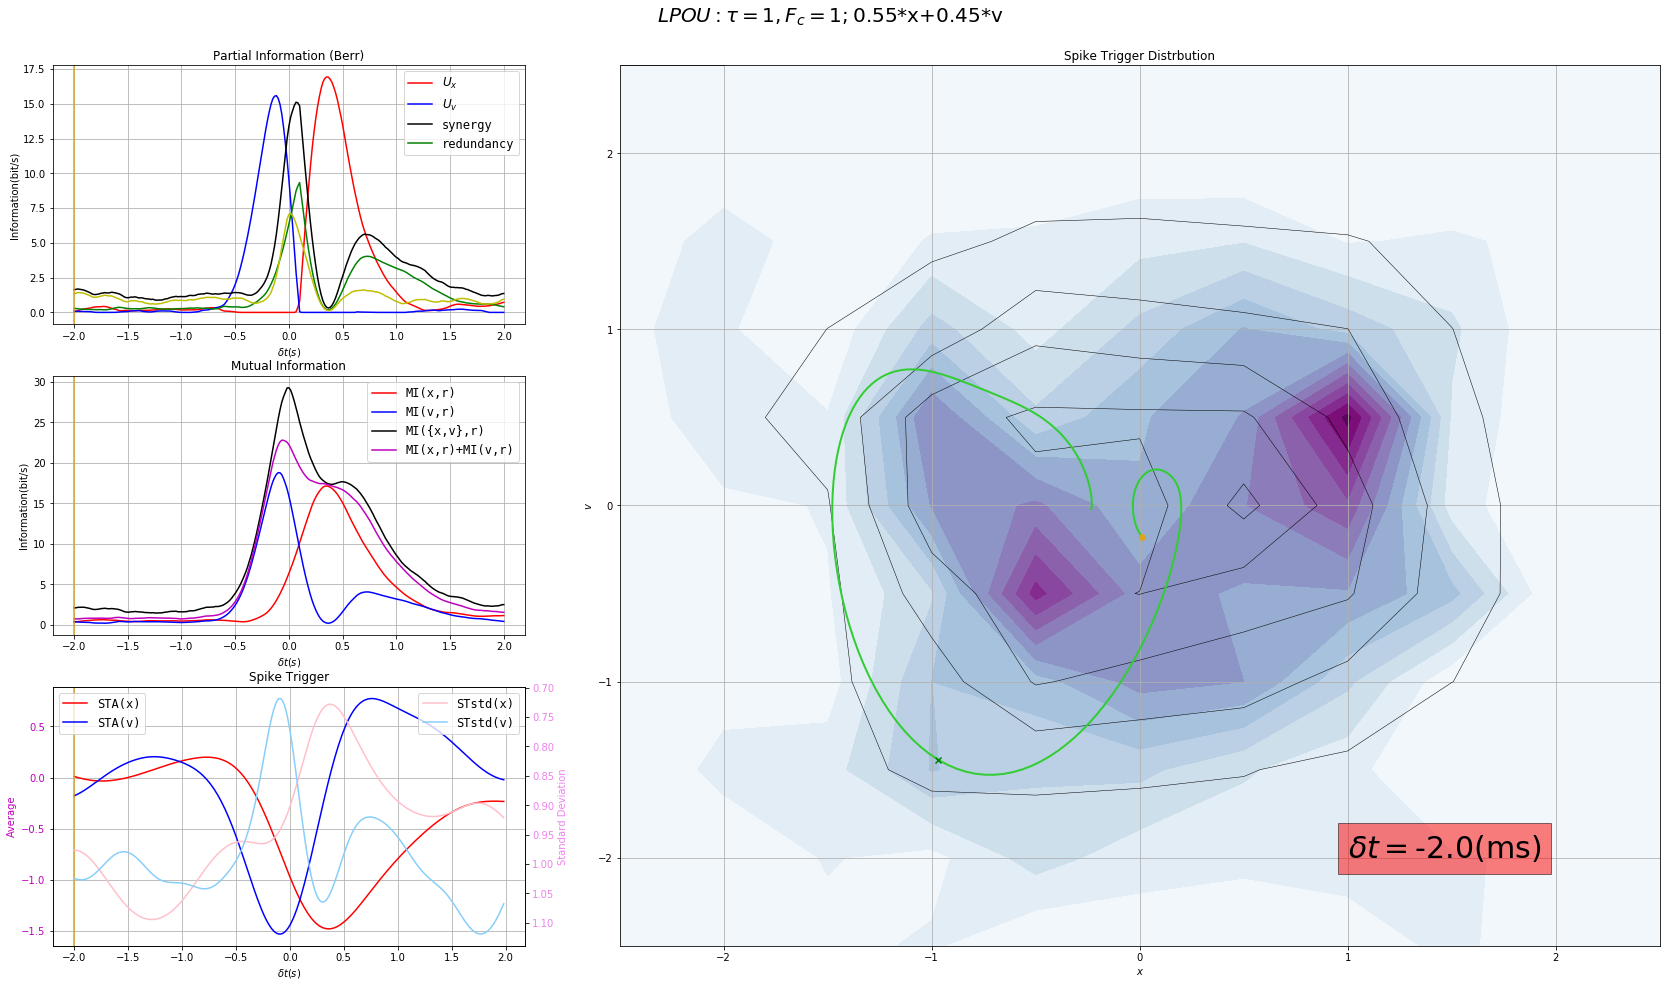

In [18]:
MIx = Information[('Beer','UIx')]+Information[('Beer','Red')]
MIv = Information[('Beer','UIv')]+Information[('Beer','Red')]
MIjoint = Information[('Beer','UIx')]+Information[('Beer','Syn')]+Information[('Beer','UIv')]+Information[('Beer','Red')]
fig = plt.figure()
fig.suptitle(r'$LPOU:\tau=1,F_c=1;$'+str(1-lamda)+'*x+'+str(lamda)+'*v', fontsize = 20, y=0.93)
ax5 = fig.add_subplot(3, 3, 1)
ax2 = fig.add_subplot(3, 3, 4)
ax3 = fig.add_subplot(3, 3, 7)
ax4 = fig.add_subplot(1, 3, (2,5))
moving = []
#MI
ax2.plot(timeshift,MIx, 'r-')
ax2.plot(timeshift,MIv, 'b-')
ax2.plot(timeshift,MIjoint, 'k-')
ax2.plot(timeshift,MIx+MIv, 'm-')
vl_mi = ax2.axvline(time[0], color = 'goldenrod')
moving.append(vl_mi)
ax2.set_title('Mutual Information')
ax2.set_xlabel(r'$\delta t(s)$')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
#PI
ax5.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax5.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax5.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax5.plot(timeshift,Information[('Beer','Red')], 'g-')
ax5.plot(timeshift,Information[('Beer','Syn')]-Information[('Beer','Red')], 'y-')
vl_pi = ax5.axvline(time[0], color = 'goldenrod')
moving.append(vl_pi)
ax5.set_title('Partial Information (Berr)')
ax5.set_xlabel(r'$\delta t(s)$')
ax5.set_ylabel('Information(bit/s)')
ax5.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax5.grid()
#STA & STstd
ax3.plot(time,xSTA,'r-')
ax3.plot(time,vSTA, 'b-')
vl_sta = ax3.axvline(time[0], color = 'goldenrod')
moving.append(vl_sta)
ax3.set_title('Spike Trigger')
ax3.set_xlabel(r'$\delta t(s)$')
ax3.set_ylabel('Average', color='m')
ax3.tick_params(axis='y', labelcolor='m')
ax3.legend( ('STA(x)', 'STA(v)'), loc='upper left', prop={'size': 'large', 'family': 'monospace'})
ax6 = ax3.twinx()
ax6.invert_yaxis()
ax6.plot(time,xSTstd,'pink')
ax6.plot(time,vSTstd,'lightskyblue')
ax6.set_ylabel('Standard Deviation', color='violet')
ax6.tick_params(axis='y', labelcolor='violet')
ax6.legend( ('STstd(x)', 'STstd(v)'), loc='upper right', prop={'size': 'large', 'family': 'monospace'})
#STdistrbution
dat = np.vstack((x,v))
edges = (np.arange(-2.75,3.,0.5),np.arange(-2.75,3.,0.5))
N, edges= np.histogramdd(dat.T, bins=edges)
Ctrs = [(edges[i][:-1]+edges[i][1:])/2 for i in [0,1]]
X, Y = np.meshgrid(Ctrs[0],Ctrs[1])
ax4.contour(Y,X,N,5, colors='black', linewidths=0.5, zorder=10)
N_list = []
for i in range(len(time)):
    dat = np.vstack((xcoll[:,i],vcoll[:,i]))
    N, edges= np.histogramdd(dat.T, bins=edges)
    N_list.append(N)
cont = ax4.contourf(Y,X,N_list[0],15, cmap=cm.BuPu, zorder=1)
moving.append(cont)
ax4.plot(xSTA,vSTA, linewidth=2,color = 'limegreen', zorder=11)
ax4.scatter(xSTA[int(len(time)/2+0.5)],vSTA[int(len(time)/2+0.5)], c='green', marker='x', zorder=12)
dot = ax4.scatter(xSTA[0],vSTA[0], c='goldenrod', zorder=13)
moving.append(dot)
ax4.set_xlabel(r'$x$')
ax4.set_ylabel(r'$v$')
ax4.set_title('Spike Trigger Distrbution')
txt = ax4.text(1, -2, r'$\delta t=$'+str(np.round(time[0],3))+'(ms)',fontsize=30,
         bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
moving.append(txt)

ax4.grid(True, zorder=100)
ax3.grid()
ax2.grid()
size_factor = 1.8
fig.set_size_inches(16*size_factor, 9*size_factor)

def animate(i):
    moving[0].set_xdata(time[i])
    moving[1].set_xdata(time[i])
    moving[2].set_xdata(time[i])
    moving[3] = ax4.contourf(Y,X,N_list[i],15, cmap=cm.BuPu, zorder=1)
    moving[4].set_offsets(np.c_[xSTA[i], vSTA[i]])
    moving[5].set_text(r'$\delta t=$'+str(np.round(time[i],3))+'(ms)')
    return (moving,)

anim = animation.FuncAnimation(fig, animate, frames=240, interval=40)

## show and save

In [19]:
# HTML(anim.to_html5_video())

In [20]:
save_folder = 'D:\\GoogleDrive\\retina\Model\\x+v-'
name = 'STAni_LPOU_tau='+str(tau)+'_Fc='+str(cutoffFreq)
anim.save(save_folder+name+'.mp4', writer='ffmpeg', fps=30)